In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

<Axes: xlabel='energy'>

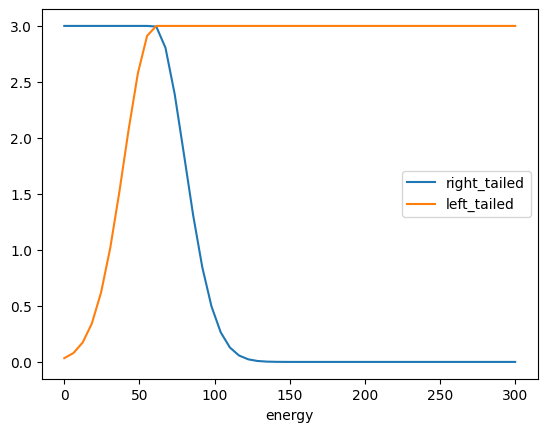

In [11]:
def right_tailed_exp(energy, val, m, v=20):
  if energy >= m:
    alpha = np.exp(-(energy - m)**2 / (v**2 * 2.0))
    val *= alpha
  return val

def left_tailed_exp(energy, val, m, v=20):
  if energy < m:
    alpha = np.exp(-(energy - m)**2 / (v**2 * 2.0))
    val *= alpha
  return val


energy = np.linspace(0, 300)
right_tailed = [right_tailed_exp(x, 3, 60) for x in energy]
left_tailed = [left_tailed_exp(x, 3, 60) for x in energy]

df = pd.DataFrame({'energy': energy, 'right_tailed': right_tailed, 'left_tailed': left_tailed})

df.set_index('energy').plot()

In [14]:
right_tailed_exp(90, 3, 60, v=15)

np.float64(0.4060058497098381)

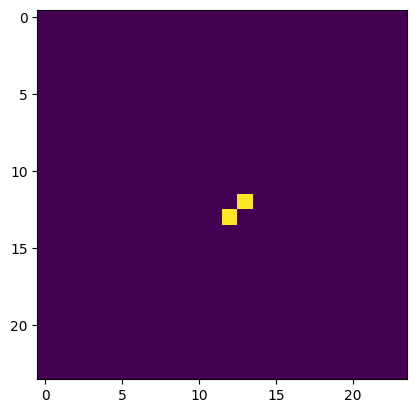

In [17]:
rows, cols = (24, 24)
x, y = np.ogrid[:rows, :cols]
pos = (12, 12)
enemy_dist = np.abs(x - pos[0]) + np.abs(y - pos[1])

init_pos = (23, 23)
enemy_init_pos_dist = 11 + 11
init_pos_dist = np.abs(x - init_pos[0]) + np.abs(y - init_pos[0])
mask = (enemy_dist == 1) & (init_pos_dist < enemy_init_pos_dist)


plt.imshow(mask)

In [22]:
np.minimum(np.array(range(5)), 2)

array([0, 1, 2, 2, 2])